# Projet 5 - Segmentez des clients d'un site e-commerce (Partie 1)

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Etudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 📊 Partie 1 : Création de l'échantillon d'apprentissage

Ce notebook contient la première partie du projet dédiée à la création de l'échantillon d'apprentissage pour la segmentation client.

Une seconde partie est dédiée à l'analyse exploratoire des données (EDA). L'objectif principal de cette section est de mieux comprendre la nature et la qualité des données afin d'identifier les transformations nécessaires pour la préparation, le feature engineering et le preprocessing des variables.

- Importer et préparer les données.
- Identifier les variables clés pour la segmentation.
- Effectuer une analyse descriptive (statistiques, visualisations, corrélations).

## ⚡ Mission

Nous sommes **consultant pour Olist** et nous avons été chargé de **réaliser cette segmentation**, en mettant en place des modèles d'**apprentissage non supervisé** et en fournissant un **plan de maintenance** du modèle.

## Documentation

- [Google Docs Notes](https://docs.google.com/document/d/1Bpxbg2jaFZpI605kQhOoR84H2_EpTwBdUt-xk82wsfM/edit?usp=sharing)
- https://github.com/Faroja/Olist-Customers-Segementation
- https://towardsdatascience.com/simple-customer-segmentation-using-rfm-analysis-1ccee2b6d8b9
- https://stackoverflow.com/questions/59315132/how-to-get-which-semester-a-day-belongs-to-using-pandas-period

In [7]:
import sqlite3
import pandas as pd
import os
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [8]:
# Set display options to show the DataFrame in full width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

### Téléchargement de la base de données SQLite

In [9]:
# Définir le chemin du dossier et l'URL
folder_path = './content/data'
file_url = 'https://course.oc-static.com/projects/olist.db'
file_name = file_url.split('/')[-1]  # Nom du fichier extrait de l'URL
file_path = os.path.join(folder_path, file_name)

# Vérifier si le dossier existe, sinon le créer
if not os.path.exists(folder_path):
  os.makedirs(folder_path)
  print(f"Dossier créé : {folder_path}")

# Vérifier si le fichier existe déjà
if os.path.exists(file_path):
  print(f"Le fichier existe déjà : {file_path}")
else:
  # Télécharger le fichier
  response = requests.get(file_url, stream=True)

  if response.status_code == 200:
    with open(file_path, 'wb') as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
    print(f"Fichier téléchargé avec succès dans {file_path}")
  else:
    print(f"Échec du téléchargement. Statut HTTP : {response.status_code}")

Le fichier existe déjà : ./content/data/olist.db


### Requête SQL sur une base de données SQLite

Cette fonction exécute une requête SQL sur une base de données SQLite et retourne les résultats sous forme de DataFrame pandas.

In [10]:
def query_data(query, db_path='./content/data/olist.db'):
  """
  Cette fonction exécute une requête SQL sur une base de données SQLite et retourne les résultats sous forme de DataFrame pandas.

  Paramètres:
  - query (str): La requête SQL à exécuter.
  - db_path (str, optionnel): Le chemin vers le fichier de la base de données SQLite. Par défaut, il est défini à './content/data/olist.db'.

  Retourne:
  - DataFrame: Les résultats de la requête SQL sous forme de DataFrame pandas.
  """
  conn = sqlite3.connect(db_path)
  data = pd.read_sql_query(query, conn)
  conn.close()
  return data

### Liste des tables dans la base de données

<img src="https://i.imgur.com/HRhd2Y0.png" width="700"/>

La base de données SQLite `olist.db` est structurée autour de plusieurs tables essentielles pour l'analyse des données clients. Voici un aperçu des tables disponibles :

1. **customers** : Contient des informations sur les clients, telles que les identifiants uniques et les données personnelles.
2. **geoloc** : Stocke les informations de géolocalisation, permettant de situer les clients et les commandes.
3. **order_items** : Détaille les articles inclus dans chaque commande, avec des informations sur les produits et les quantités.
4. **order_pymts** : Enregistre les paiements associés aux commandes, incluant les méthodes de paiement et les montants.
5. **order_reviews** : Centralise les avis et notes laissés par les clients sur leurs commandes, offrant un aperçu de la satisfaction client.
6. **orders** : Liste toutes les commandes passées, avec des détails sur les dates, les statuts et les identifiants clients.
7. **products** : Répertorie les produits disponibles, incluant des descriptions et des catégories.
8. **sellers** : Fournit des informations sur les vendeurs, tels que les identifiants et les localisations.
9. **translation** : Contient des traductions pour divers éléments de la base de données, facilitant l'accès multilingue.

Ces tables permettent une analyse approfondie des comportements d'achat et des préférences des clients, essentielle pour la segmentation et les stratégies marketing.

In [11]:
# Créer une requête SQL pour lister les tables
query = "SELECT name FROM sqlite_master WHERE type='table';"

# Exécuter la requête et récupérer les données dans un DataFrame
tables_df = query_data(query)

# Afficher le DataFrame
print("Tables dans la base de données :")
print(tables_df)


Tables dans la base de données :
            name
0      customers
1         geoloc
2    order_items
3    order_pymts
4  order_reviews
5         orders
6       products
7        sellers
8    translation


### Importation des tables dans des DataFrames

In [12]:
orders_table = query_data("SELECT * FROM orders")
order_pymts_table = query_data("SELECT * FROM order_pymts")
order_reviews_table = query_data("SELECT * FROM order_reviews")
customers_table = query_data("SELECT * FROM customers")

### Création des données de commandes

Pour obtenir une vue d'ensemble complète des commandes, nous fusionnons les tables `orders`, `customers`, `order_pymts` et `order_reviews`. Cette opération permet de centraliser toutes les informations pertinentes concernant chaque commande, y compris les détails des clients, les méthodes de paiement et les avis laissés par les clients.

**Points d'attention** :

- **Paiements** : Certaines commandes ont plusieurs paiements. Nous regroupons ces paiements en une seule ligne par commande en additionnant les montants.
- **Score de satisfaction** : Certaines commandes ont plusieurs avis. Nous calculons la moyenne des scores de satisfaction pour ces commandes.

#### Traitement rélisés

- Filtre les commandes par `order_status == 'delivered'`.
- Supprimer les lignes avec des valeurs manquantes dans `payment_value` et  `review_score`.
- Convertit la colonne `order_purchase_timestamp` en format datetime.

In [61]:
def process_orders(orders_table, customers_table, order_pymts_table, order_reviews_table):
  """
  Cette fonction fusionne les tables 'orders', 'customers', 'order_pymts' et 'order_reviews' en une seule table.
  """
  # Regrouper par commandes ('order_id') et additionner les montants payés
  order_pymts_total = order_pymts_table.groupby('order_id', as_index=False)['payment_value'].sum()  
  # Regrouper par commandes ('order_id') et calculer la moyenne des score de satisfaction
  mean_review_scores = order_reviews_table.groupby('order_id')['review_score'].mean().reset_index()
  # Jointure des DataFrames
  processed_orders = orders_table.merge(customers_table, on='customer_id', how='left')
  processed_orders = processed_orders.merge(order_pymts_total, on='order_id', how='left')
  processed_orders = processed_orders.merge(mean_review_scores, on='order_id', how='left')

  # Filtrer les commande par 'order_status'
  processed_orders = processed_orders[processed_orders['order_status'] == 'delivered']

  # Supprimer les lignes avec des valeurs manquantes dans 'payment_value'
  processed_orders = processed_orders.dropna(subset=['payment_value', 'review_score'])

  # Convertir la colonne 'order_purchase_timestamp' au format datetime
  processed_orders['order_purchase_timestamp'] = pd.to_datetime(processed_orders['order_purchase_timestamp'])

  # Sélectionner les colonnes à conserver
  cols_to_keep = ['order_id', 'order_purchase_timestamp', 'customer_unique_id', 'payment_value', 'review_score']
  processed_orders = processed_orders[cols_to_keep]

  processed_orders = processed_orders.reset_index(drop=True)

  return processed_orders

In [62]:
processed_orders = process_orders(orders_table, customers_table, order_pymts_table, order_reviews_table)

print(processed_orders.shape)
processed_orders.head()

(95831, 5)


,order_id,order_purchase_timestamp,customer_unique_id,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,38.71,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,141.46,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,179.12,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,72.20,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,28.62,5.0


### Exportation des données des commandes

Nous exportons les données des commandes aux format .csv.

In [ ]:
export_orders = False
if export_orders:
    processed_orders.to_csv('./content/data/processed_orders.csv', index=False)
    print("processed_orders DataFrame exported to './content/data/processed_orders.csv'")

processed_orders DataFrame exported to './content/data/processed_orders.csv'


### Création des Données pour la Segmentation RFM et le Score de Satisfaction  

L'objectif est de **grouper les informations relatives aux commandes pour chaque client**. Chaque ligne du tableau représente **un client unique**, identifié par `customer_unique_id`. Les variables suivantes sont générées pour réaliser la segmentation :  

- **`customer_unique_id`** (*Index*) : Identifiant unique du client.  
- **`recency`** (*Récence*) : Nombre de jours écoulés depuis la dernière commande passée.  
- **`frequency`** (*Fréquence*) : Nombre total de commandes effectuées par le client.  
- **`monetary_value`** (*Montant*) : Somme totale des dépenses réalisées par le client.  
- **`avg_review_score`** (*Score de satisfaction*) : Moyenne des notes attribuées par le client aux commandes passées.  

🔎 **Filtrage temporel** :  

Les commandes peuvent être filtrées selon une période spécifique (comme par exemple une année ou un trimestre) afin d’analyser l'évolution du comportement des clients au fil du temps.

In [64]:
def create_rfm_df(df, start_date = datetime(2017, 1, 1), end_date = datetime(2017, 12, 31, 23, 59, 59)):
    """
    Fonction pour créer les colonnes RFM (Récence, Fréquence, Montant) et score de satisfaction à partir des données des commandes.

    Args:
    - df (pd.DataFrame): Le DataFrame contenant les commandes.

    Returns:
    - pd.DataFrame: Le DataFrame contenant les colonnes RFM et score de satisfaction.
    """
    # Filtrer les commandes pour la période spécifiée
    df = df[(df['order_purchase_timestamp'] >= start_date) & (df['order_purchase_timestamp'] <= end_date)]

    print("Date max : ", df['order_purchase_timestamp'].max())

    # Si des commandes existents
    if not df.empty:

        # Créer une table pivot pour RFM
        rfm_df = df.pivot_table(
            index='customer_unique_id',
            values='order_purchase_timestamp',
            aggfunc={'order_purchase_timestamp': 'max'}
        )

        rfm_df.rename(columns={'order_purchase_timestamp': 'most_recent_purchase'}, inplace=True)

        period_end_timestamp = pd.Timestamp(end_date)

        rfm_df['recency'] = (period_end_timestamp - rfm_df['most_recent_purchase']).dt.days
        rfm_df['frequency'] = df.groupby('customer_unique_id').size()
        rfm_df['monetary_value'] = df.groupby('customer_unique_id')['payment_value'].sum()
        rfm_df['avg_review_score'] = df.groupby('customer_unique_id')['review_score'].mean()

        rfm_df = rfm_df.drop(columns='most_recent_purchase')

        return rfm_df

    else:
        print(f"Aucune commandes trouvées pour la période : {start_date} à {end_date}")
        return None

#### Création des données client pour l'année 2017

Pour établir une **segmentation client de référence**, nous utiliserons les données de l'année **2017** afin de réaliser un **clustering "baseline"**. Ensuite, nous analyserons l'évolution de la stabilité des clusters sur différentes périodes.

In [52]:
rfm_2017 = create_rfm_df(processed_orders)
print(rfm_2017.shape)
print(rfm_2017.head(10))

Date max :  2017-12-31 23:29:31
(41824, 4)
                                  recency  frequency  monetary_value  avg_review_score
customer_unique_id                                                                    
0000f46a3911fa3c0805444483337064      296          1           86.22               3.0
0000f6ccb0745a6a4b88665a16c9f078       80          1           43.62               4.0
0004aac84e0df4da2b147fca70cf8255       47          1          196.89               5.0
0005e1862207bf6ccc02e4228effd9a0      302          1          150.12               4.0
0006fdc98a402fceb4eb0ee528f6a8d4      166          1           29.00               3.0
00082cbe03e478190aadbea78542e933       42          1          126.26               5.0
000a5ad9c4601d2bbdd9ed765d5213b3      142          1           91.28               4.0
000bfa1d2f1a41876493be685390d6d3       93          1           46.85               4.5
000c8bdb58a29e7115cfc257230fb21b       19          1           29.00               5.0


In [53]:
missing_values = rfm_2017.isnull().sum()
print(missing_values)

recency             0
frequency           0
monetary_value      0
avg_review_score    0
dtype: int64


## 🧪 Analyse Exploratoire

Dans cette section, nous explorerons les données clients RFM+S générées :

- **Nombre de commandes par client** : Distribution de la fréquence des achats pour chaque client.
- **Jours depuis la dernière commande** : Distribution du temps écoulé depuis le dernier achat.
- **Montant total dépensé** : Distribution des dépenses cumulées par client.
- **Distribution des moyennes des scores de satisfaction** : Distribution des niveaux de satisfaction moyens des clients.

### Commandes par client

Nous observons qu'une très grande majorité des clients n'ont effectué qu'une seule commande. Par conséquent, la fréquence d'achat sera une dimension moins discriminante dans notre segmentation RFM.

In [54]:
# Créer un dataframe avec la distribution de fréquence et les valeurs absolues
order_counts = rfm_2017['frequency'].value_counts()
frequency_distribution = (rfm_2017['frequency'].value_counts(normalize=True) * 100).round(4)
frequency_df = pd.DataFrame({
    'distribution in frequency (%)': frequency_distribution,
    'absolute value': order_counts
})

print(frequency_df)

           distribution in frequency (%)  absolute value
frequency                                               
1                                97.2313           40666
2                                 2.5559            1069
3                                 0.1674              70
4                                 0.0311              13
5                                 0.0096               4
6                                 0.0024               1
8                                 0.0024               1


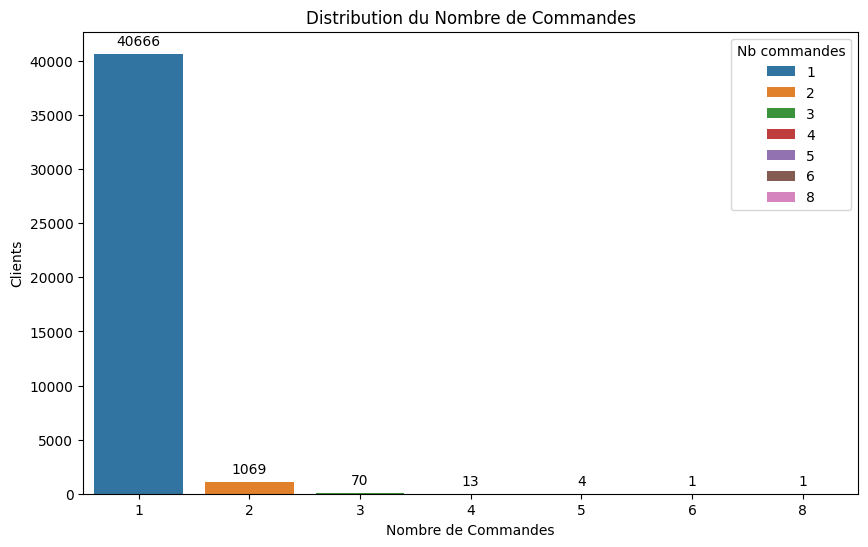

In [55]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=frequency_df.index, y=frequency_df['absolute value'], hue=frequency_df.index, palette='tab10')
ax.legend(title='Nb commandes')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

plt.title('Distribution du Nombre de Commandes')
plt.xlabel('Nombre de Commandes')
plt.ylabel('Clients')
plt.show()


### Jours depuis la dernière commande

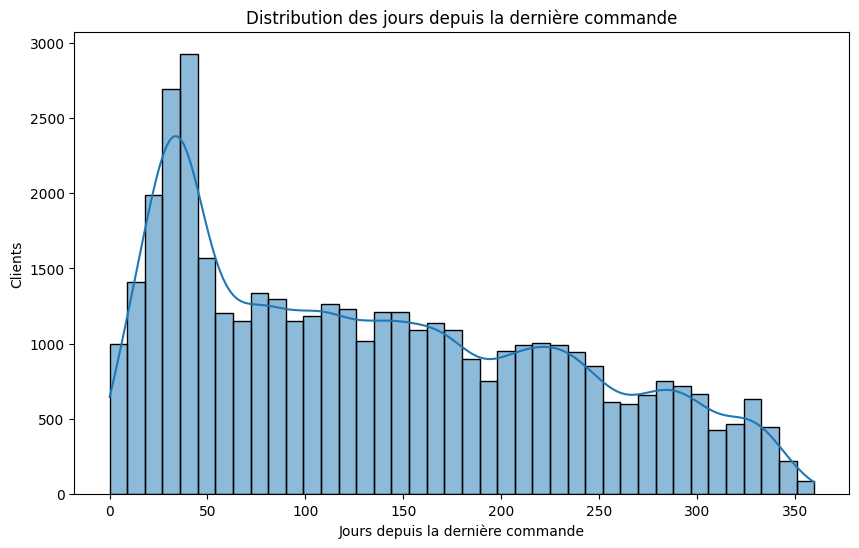

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_2017['recency'], bins=40, kde=True)
plt.title('Distribution des jours depuis la dernière commande')
plt.xlabel('Jours depuis la dernière commande')
plt.ylabel('Clients')
plt.show()

### Montant total dépensé

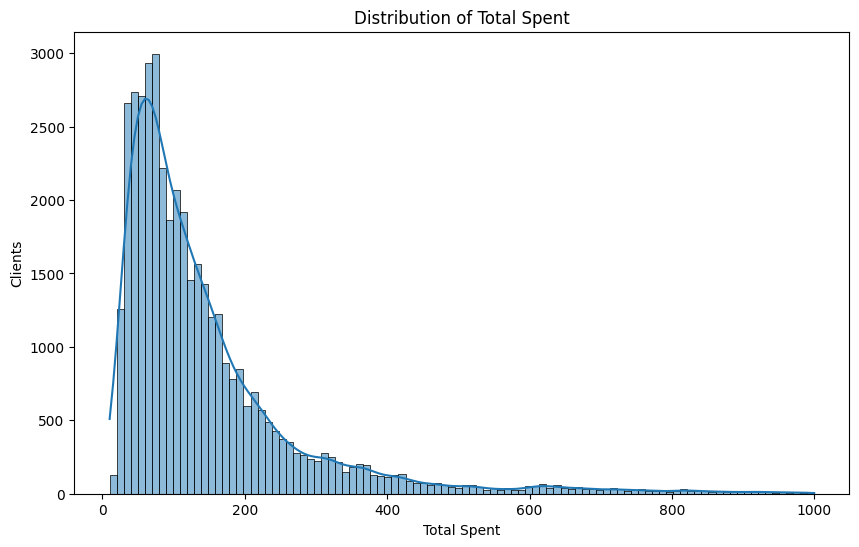

In [60]:
rfm_df_max_spent = rfm_2017[rfm_2017['monetary_value'] <= 1000]

plt.figure(figsize=(10, 6))
sns.histplot(rfm_df_max_spent['monetary_value'], bins=100, kde=True)
plt.title('Distribution of Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Clients')
plt.show()

### Moyenne des scores de satisfaction

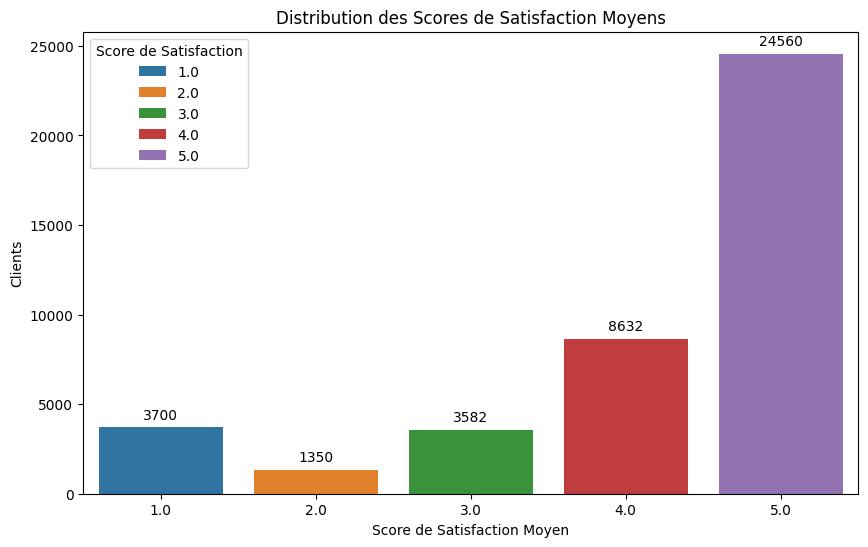

In [59]:
# Count the occurrences of each avg_review_score
review_score_counts = rfm_2017['avg_review_score'].round().value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=review_score_counts.index, y=review_score_counts.values, hue=review_score_counts.index, palette='tab10')
ax.legend(title='Score de Satisfaction')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

plt.title('Distribution des Scores de Satisfaction Moyens')
plt.xlabel('Score de Satisfaction Moyen')
plt.ylabel('Clients')
plt.show()